In [49]:
import numpy as np
import matplotlib as mpl
%pylab inline
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
#Probability libraries
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV
from scipy.stats import gaussian_kde


Populating the interactive namespace from numpy and matplotlib


C:\Users\andres\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Use this webpage for info: https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

In [50]:
#Fitt Functions
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


In [88]:
#Loading Data
#Oligocene-Lower Miocene DZ
Hist1=loadtxt("Andes(Oli-EarlyMio).txt")
#Middle Miocene-Pliocene DZ
Hist2=loadtxt("Andes(MMio-Pliocene).txt")
#Ecuador Signature
EcuadorH1=loadtxt("Ecuador (EarlyMiddMio).txt") #La muestra mas joven
EcuadorH2=loadtxt("Ecuador (OliEarlyMi).txt") #Todos menos la muestra mas joven
EcuadorH3=loadtxt("Ecuador (OliEarMio).txt") #Todos los datos juntos
#Cauca Signature
#10 Ma and 2 Ma
LaPaila=loadtxt("Zarzal.txt") #Datos La Paila Fm.
Zarzal=loadtxt("LaPaila.txt") #Datos Zarsal Fm.
#Upper Miocene-Pliocene (Tumaco)
Tumaco1=loadtxt("Tumaco(Pliocene).txt")
#Lower-Middle Miocene (Tumaco)
Tumaco2=loadtxt("Tumaco(middleMiocene).txt")
#Middle-Upper Miocene (Cauca-Patia)
Patia1=loadtxt("CanalBasin (Oligocene-Lower Miocene).txt")
#Lower Miocene (Cauca-Patia)
Patia2=loadtxt("CaucaPatia(LowerMiocene).txt")

In [52]:
#Loading Data
#Data to Compare
Intrusives=loadtxt("PanamaIntrusives.txt")
ModernSediments=loadtxt("PModernSediments.txt")
PanamaData=loadtxt("PanamaData.txt")

In [74]:
#Operations
Hist1C=[]
Hist1NC=[]
Hist2C=[]
Hist2NC=[]
EcuadorH3C=[]
EcuadorH3NC=[]
PanamaC=[]
PanamaNC=[]
Hist2P=[]
Hist2NP=[]
# DZ with Cenozoic age (Oligocene-Lower Miocene, Andes)
for i in range (0,len(Hist1)):
    if Hist1[i]<=66:
        Hist1C.append(Hist1[i])
    else:
    #Other DZ
        Hist1NC.append(Hist1[i])
    
# DZ with Panamanian signature (Middle Miocene-Pliocene, Andes)
for i in range (0,len(Hist2)):
    if Hist2[i]<=40 and Hist2[i]>=30:
        Hist2P.append(Hist2[i])
    else:
    #Other DZ
        Hist2NP.append(Hist2[i])    
        
# DZ with Cenozoic age (Oligocene-Lower Miocene, Ecuador)
for i in range (0,len(EcuadorH3)):
    if EcuadorH3[i]<=66:
        EcuadorH3C.append(EcuadorH3[i])
    else:
    #Other DZ
        EcuadorH3NC.append(EcuadorH3[i])
        
# DZ with Cenozoic age (Oligocene-Lower Miocene, Panama)
for i in range (0,len(PanamaData)):
    if PanamaData[i]<=66:
        PanamaC.append(PanamaData[i])
    else:
    #Other DZ
        PanamaNC.append(PanamaData[i])

In [23]:
# DZ with Cenozoic age (Middle Miocene,Andes)
for i in range (0,len(Hist2)):
    if Hist2[i]<=66:
        Hist2C.append(Hist2[i])
    else:
    #Other DZ
        Hist2NC.append(Hist2[i])


# Histogramas

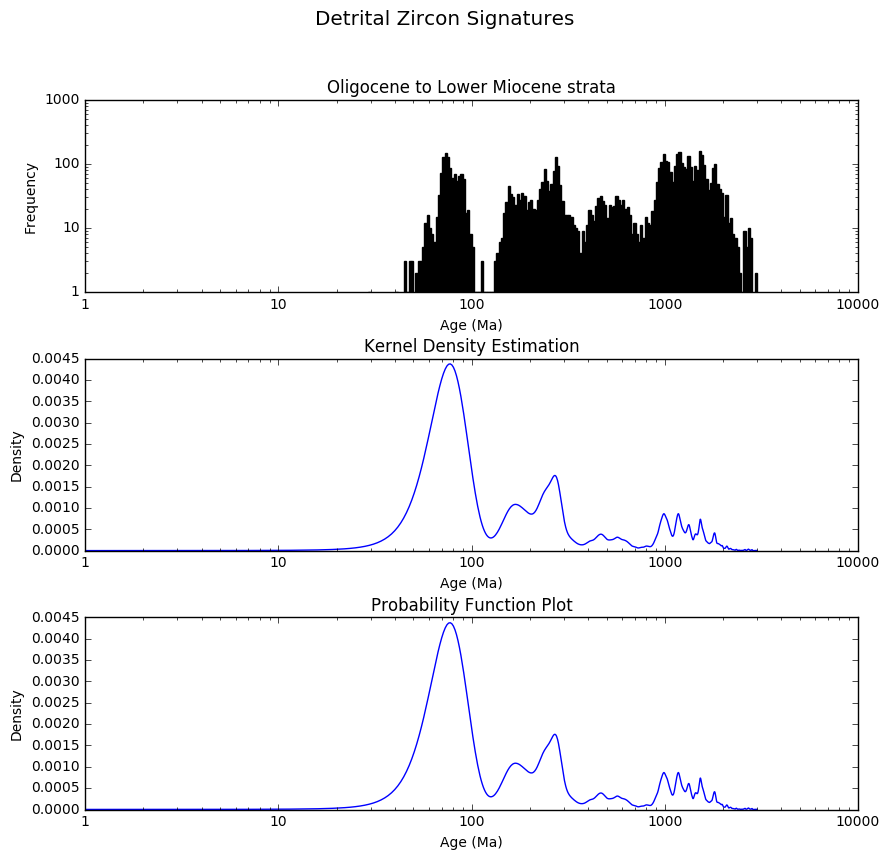

In [102]:
#Histograma 1
F1=figure(1, figsize=(9, 9))
st=F1.suptitle("Detrital Zircon Signatures",fontsize="x-large")

sF1=F1.add_subplot(311)
hist(Hist1, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='black')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
xlabel("Age (Ma)")
ylabel("Frequency")
sF1.set_title("Oligocene to Lower Miocene strata")

#Kernel Estimation
sF2=F1.add_subplot(312)
x1_grid=linspace(1,3000,2000)


plot(x1_grid,kde_sklearn(Hist1,x1_grid,bandwidth=15))
gca().set_xscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
xlabel("Age (Ma)")
ylabel("Density")
sF2.set_title("Kernel Density Estimation")

#Probability density estomation
sF3=F1.add_subplot(313)
plot(x1_grid,kde_scipy(Hist1,x1_grid,bandwidth=15))
gca().set_xscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
xlabel("Age (Ma)")
ylabel("Density")
sF3.set_title("Probability Function Plot")

F1.tight_layout()
st.set_y(0.95)
F1.subplots_adjust(top=0.85)

savefig('DZ_Oligocene_Lower Miocene.png')


In [101]:
#Best bandwidth

#Oligocene-Lower Miocene
grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.1, 15, 50)},cv=20) # 20-fold cross-validation
grid.fit(Hist1[:, None])
print grid.best_params_

#Middle Miocene-Pliocene
grid1 = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.1, 15, 50)},cv=20) # 20-fold cross-validation
grid1.fit(Hist2[:, None])
print grid1.best_params_

{'bandwidth': 15.0}
{'bandwidth': 7.3979591836734686}


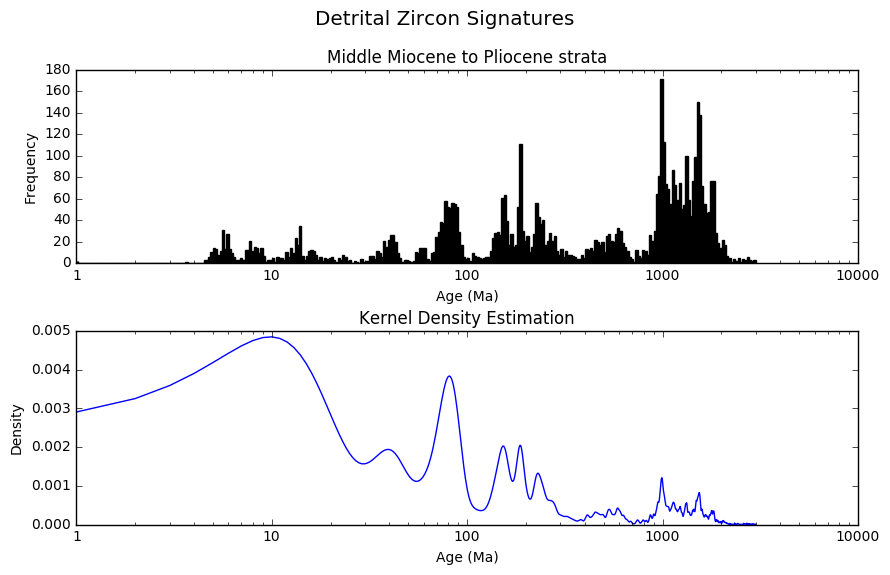

In [124]:
#Histograma 2
F2=figure(2, figsize=(9,6))
st=F2.suptitle("Detrital Zircon Signatures",fontsize="x-large")
x1_grid=linspace(1,3000,3000)

sF1=F2.add_subplot(211)
hist(Hist2, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='black')
gca().set_xscale("log")
#gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
sF1.set_title("Middle Miocene to Pliocene strata")
xlabel("Age (Ma)")
ylabel("Frequency")

sF2=F2.add_subplot(212)
plot(x1_grid,kde_sklearn(Hist2,x1_grid,bandwidth=7.4))
gca().set_xscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
sF2.set_title("Kernel Density Estimation")

xlabel("Age (Ma)")
ylabel("Density")

F2.tight_layout()
st.set_y(0.95)
F2.subplots_adjust(top=0.85)


savefig('DZ_Middle Miocene_Pliocene.png')

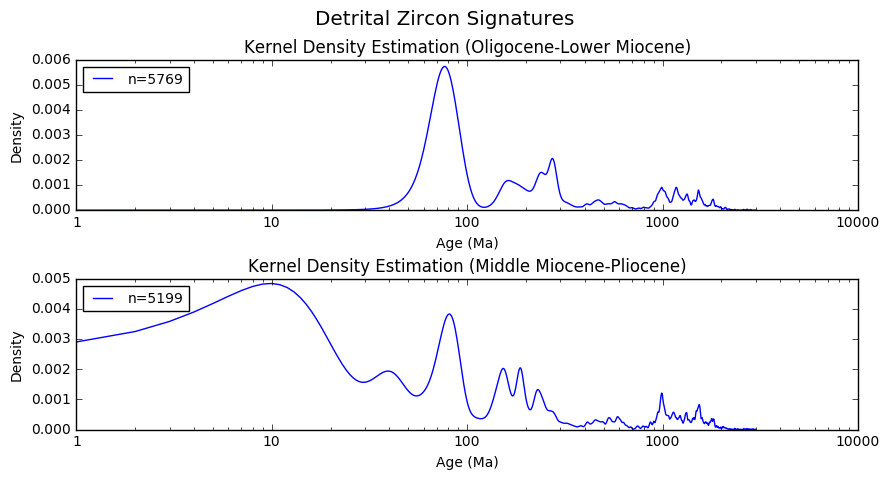

In [123]:
#Comparison distributions

F3=figure(2, figsize=(9,5))
st=F3.suptitle("Detrital Zircon Signatures",fontsize="x-large")
x1_grid=linspace(1,3000,3000)
x2_grid=linspace(1,3000,3000)

sF1=F3.add_subplot(211)
plot(x1_grid,kde_sklearn(Hist1,x1_grid,bandwidth=10),label='n={0}'.format(len(Hist1)))
gca().set_xscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
xlabel("Age (Ma)")
ylabel("Density")
sF1.set_title("Kernel Density Estimation (Oligocene-Lower Miocene)")
legend(loc='upper left',fontsize = 'medium')

sF2=F3.add_subplot(212)
plot(x2_grid,kde_sklearn(Hist2,x2_grid,bandwidth=7.4),label='n={0}'.format(len(Hist2)))
gca().set_xscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
sF2.set_title("Kernel Density Estimation (Middle Miocene-Pliocene)")
xlabel("Age (Ma)")
ylabel("Density")
legend(loc='upper left',fontsize = 'medium')

F3.tight_layout()
st.set_y(0.95)
F3.subplots_adjust(top=0.85)


savefig('DZ_Kernel Density.png')

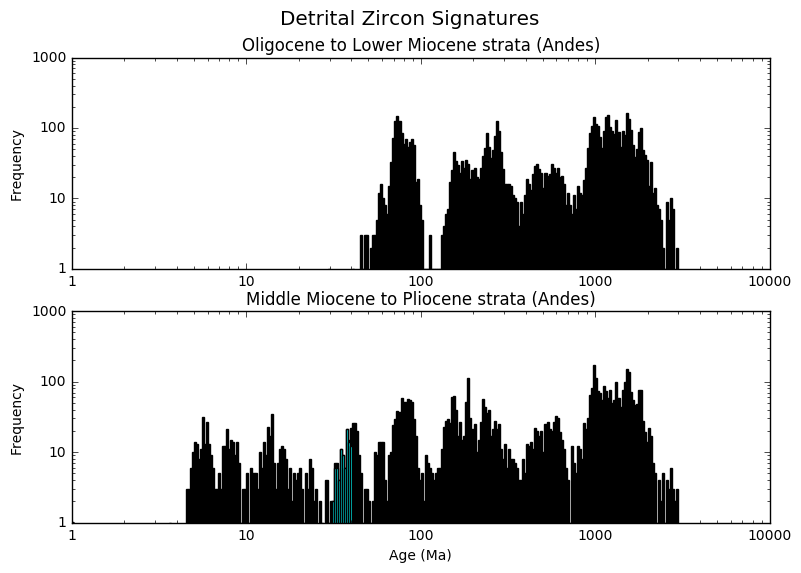

In [91]:
#Comparison

fig5=figure(5, figsize=(9,6))
st=fig5.suptitle("Detrital Zircon Signatures",fontsize="x-large")


s1=fig5.add_subplot(211)
hist(Hist1, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='black')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s1.set_title("Oligocene to Lower Miocene strata (Andes)")
ylabel("Frequency")

s2=fig5.add_subplot(212)
hist(Hist2, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='black')
hist(Hist2P, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='cyan')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s2.set_title("Middle Miocene to Pliocene strata (Andes)")
ylabel("Frequency")

xlabel("Age (Ma)")

savefig('DZ_Oligocene-Pliocene(Andes).png')



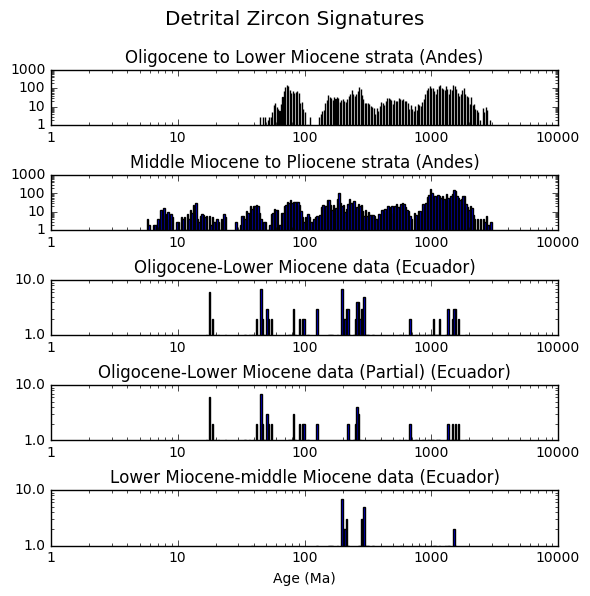

In [29]:
fig5=figure(5, figsize=(6,6))
st=fig5.suptitle("Detrital Zircon Signatures",fontsize="x-large")

s1=fig5.add_subplot(511)
hist(Hist1, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),width=0.1,color='blue')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s1.set_title("Oligocene to Lower Miocene strata (Andes)")

s2=fig5.add_subplot(512)
hist(Hist2, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='blue')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s2.set_title("Middle Miocene to Pliocene strata (Andes)")

s3=fig5.add_subplot(513)
hist(EcuadorH3, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='blue')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s3.set_title("Oligocene-Lower Miocene data (Ecuador)")

s4=fig5.add_subplot(514)
hist(EcuadorH2, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='blue')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s4.set_title("Oligocene-Lower Miocene data (Partial) (Ecuador)")

s5=fig5.add_subplot(515)
hist(EcuadorH1, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='blue')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s5.set_title("Lower Miocene-middle Miocene data (Ecuador)")

fig5.tight_layout()
st.set_y(0.95)
fig5.subplots_adjust(top=0.85)
xlabel("Age (Ma)")

savefig('DZ_Andes_Ecuador.png')

# Whisk & Whisker Plots



In [30]:
# OB=Oriente Basin
#PB-PR=Panama basins-Rivers(Canal, Cobachon, Modern Rivers=PanamaData.txt)
#NAR1=Northern Andes (Oligocene-Lower Miocene)
#NAR2= Northern Andes (Middle Miocene-Pliocene)

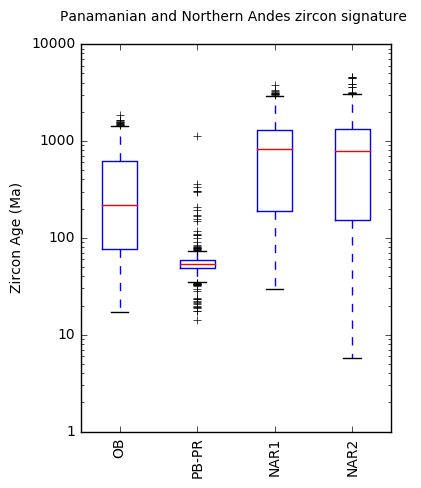

In [31]:
#Diagrama 1
data1=[EcuadorH3,PanamaData,Hist1,Hist2]
fig1=figure(3, figsize=(4, 5))
ax1=fig1.add_subplot(111)
gca().set_yscale("log")
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
box1=ax1.boxplot(data1)
title("Panamanian and Northern Andes zircon signature \n",size=10)
ax1.set_xticklabels(['OB','PB-PR','NAR1','NAR2'],rotation='vertical')
ylabel("Zircon Age (Ma)")
savefig('DZ_NAndes_Panama_Whisker(full signature).png')

In [32]:
#Kolmogorov–Smirnov test
#Northern Andes strata- (Oligocene-Lower Miocene & Middle Miocene-Pliocene)
stats.ks_2samp(Hist2, Hist1)

Ks_2sampResult(statistic=0.1130299263656924, pvalue=7.600787302295685e-29)

Distribution of Oligocene-Lower Miocene cant be the same that Middle Miocene-Pliocene in Northern Andes Data.Very Low P-value and not small D value.

In [33]:
#Kolmogorov–Smirnov test
#Northern Andes strata- (Oligocene-Lower Miocene & Panama detrital zircon data)
stats.ks_2samp(PanamaData,Hist1)

Ks_2sampResult(statistic=0.89705418676517179, pvalue=3.061578892489466e-304)

Distribution of Oligocene-Lower Miocene cant be the same distribution of Oligocene-Lower Miocene data reported in Panamanian strata. Very Low p-value and high D value.

In [34]:
#Kolmogorov–Smirnov test
#Northern Andes strata- (Middle Miocene-Pliocene & Panama detrital zircon data)
stats.ks_2samp(PanamaData,Hist2)

Ks_2sampResult(statistic=0.79689553219448095, pvalue=1.3346160417857752e-235)

Distribution of Oligocene-Lower Miocene cant be the same distribution of Oligocene-Lower Miocene data reported in Panamanian strata. Very Low p-value and high D value.

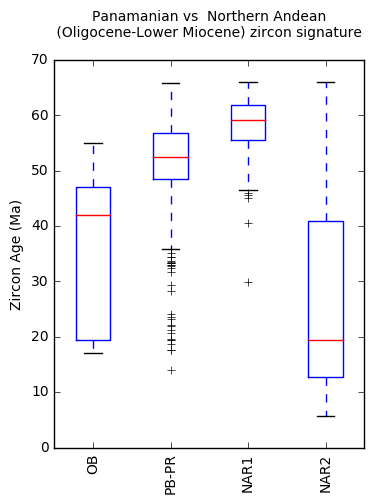

In [35]:
data1=[EcuadorH3C,PanamaC,Hist1C,Hist2C]
fig1=figure(3, figsize=(4, 5))
ax1=fig1.add_subplot(111)
ylim(0,70)
box1=ax1.boxplot(data1)
title("Panamanian vs  Northern Andean\n (Oligocene-Lower Miocene) zircon signature \n",size=10)
ax1.set_xticklabels(['OB','PB-PR','NAR1','NAR2'],rotation='vertical')
ylabel("Zircon Age (Ma)")
savefig('DZ_NAndes_Panama_Whisker(Cenozoic signature).png')


In [36]:
#Northern Andes strata- (Oligocene-Lower Miocene & Panama strata)
stats.ks_2samp(PanamaData,Hist1C)

Ks_2sampResult(statistic=0.40613590263691685, pvalue=4.81967804152209e-11)

Distribution of Oligocene-Lower Miocene cant be the same that Middle Miocene-Pliocene in Northern Andes Data.Very Low P-value and not small D value.

In [37]:
#Northern Andes strata- (Middle Miocene-Pliocene & Panama strata)
stats.ks_2samp(PanamaData,Hist2C)

Ks_2sampResult(statistic=0.74733349493970058, pvalue=2.1829605404552406e-126)

Distribution of Middle Miocene-Pliocene cant be the same that Middle Miocene-Pliocene in Northern Andes Data.Very Low P-value and not small D value. However, this can be related to a major proportion of Oligocene-Upper Miocene DZ ages over Eocene DZ.

In [38]:
len(Hist1)

5769

In [39]:
len(Hist2)

4566